In [1]:
#Importing modules, tools, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
#watch added .api here
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler


#importing main dataframe as df
df = pd.read_csv('data/kc_house_data.csv')

### Data Cleaning

In [2]:
#Converting grade column to an int value

#Create a dummy list
grade_num = []

#Go through each row, grabbing the first index off the string, conver to int
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))

#drop the old column and add the new
df['grade_num'] = grade_num
df.drop('grade', axis = 1);

Converting the grade to a numeric value allows us to treat it as continuous data, rather than categorical.  For the sake of consistency, it was descided to keep the scale provided by the city. 

In [3]:
# Turning NaNs in the waterfront data into NO's, then converting waterfront to binary.
# 0 is a waterfront no, 1 is a waterfront yes
#

df.waterfront.fillna(value='NO', inplace = True)
df.waterfront.replace( to_replace = ['NO','YES'], value =  [0,1], inplace = True)

A quick check on a random sample of the NaN's within the waterfront column via the lat/long provided showed that these properties were not on the waterfront. It was decided that we'd fill in the Nan's as nos.

12764    13540
7245     12050
3910     10040
9245      9890
8085      9640
         ...  
11488      420
8614       410
21316      390
860        380
15367      370
Name: sqft_living, Length: 21597, dtype: int64
4980.0


<AxesSubplot:ylabel='Frequency'>

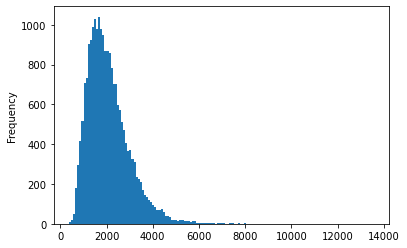

In [4]:
print(df['sqft_living'].sort_values(ascending = False))
#Those are some big results.
print(df['sqft_living'].quantile(0.99))
# even the 99 percentile is still sub 5000. 
binvar = np.sqrt(df.sqft_living.count())
df['sqft_living'].plot(kind = 'hist', bins = int(binvar))
#Plotting this shows a bit skew right.

#It may be wise to shave the model off around there.

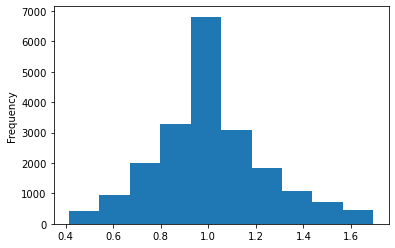

In [5]:
df.sqft_living.describe()
df['sqft_living_ratio'] = df['sqft_living'] / df['sqft_living15']
df.sqft_living_ratio.describe()

df['sqft_living_ratio'] = df.sqft_living / df.sqft_living15
df['sqft_living_ratio'] = df['sqft_living_ratio'].loc[(np.abs(stats.zscore(df.sqft_living_ratio)) < 2)]
df = df.dropna(subset = ['sqft_living_ratio'])
df.sqft_living_ratio.plot.hist();

In [6]:
print(df['sqft_lot'].sort_values(ascending = False)) 
#Holy cow! I don't think those are residential sales.
print(df['sqft_lot'].quantile(0.99))
#99th quantile, still high, still well below those outliers

#df['sqft_lot'].plot(kind = 'hist', bins = ???);
#Some weirdness at the far end


1717     1651359
17305    1164794
7640     1074218
3945      982998
4437      982278
          ...   
21536        638
20588        635
3449         609
7582         600
5821         572
Name: sqft_lot, Length: 20621, dtype: int64
206478.8


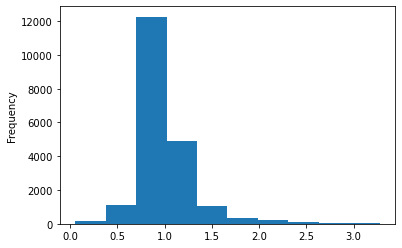

In [7]:
df.sqft_lot15.describe()
df['sqft_lot_ratio'] = df['sqft_lot'] / df['sqft_lot15']
df.sqft_lot_ratio.describe()

df['sqft_lot_ratio'] = df.sqft_lot / df.sqft_lot15
df['sqft_lot_ratio'] = df['sqft_lot_ratio'].loc[(np.abs(stats.zscore(df.sqft_lot_ratio)) < 2)]
df = df.dropna(subset = ['sqft_lot_ratio'])
df.sqft_lot_ratio.plot.hist();

The data exploration above showed some outliers. The 'sqft_~_ratio' variables were created to weed out outliers. In effect, if a lot size or living sq ft size was too different from the neighboring property, then it was deemed an outlier. Dropping outliers this way allowed us to, e.g. keep a large mansion in a neighborhood of large mansions.

In [8]:
df.bedrooms.value_counts()

df = df[df['bedrooms'] < 33]

One house had wildely more bedrooms than any other, and was cut as an outlier.

In [9]:
df['view'] = df['view'].replace({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'FAIR': 3, 'EXCELLENT':4}).fillna(0)

## Make categorical? Ordinal?

As with grade, it was decided that we should process view as non-categorical to keep the progressive relationship from rank to rank. 

In [10]:
df['floors'].value_counts()
#Seems reasonable. 

1.0    10240
2.0     7673
1.5     1757
3.0      575
2.5      134
3.5        6
Name: floors, dtype: int64

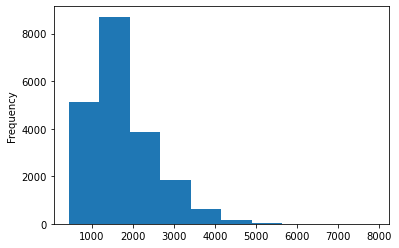

In [11]:
#cleaning the square feet above ground data
df['sqft_above'].sort_values(ascending = False) 
df['sqft_above'].quantile(.99)
#Not quite as extreme as sqft_livable


df['sqft_above'].plot(kind='hist');

In [12]:
#cleaning the basement data
df['sqft_basement'] = df['sqft_basement'].replace({'?': 0.0})
df['sqft_basement'] = df['sqft_basement'].astype(float)

Lacking other information, it was decided to assume that unknown basement square footage would be captured in sqft_livable and ? was set to 0. 

Now that the data has been given a preliminary cleaning, a correlation heatmap was generated.


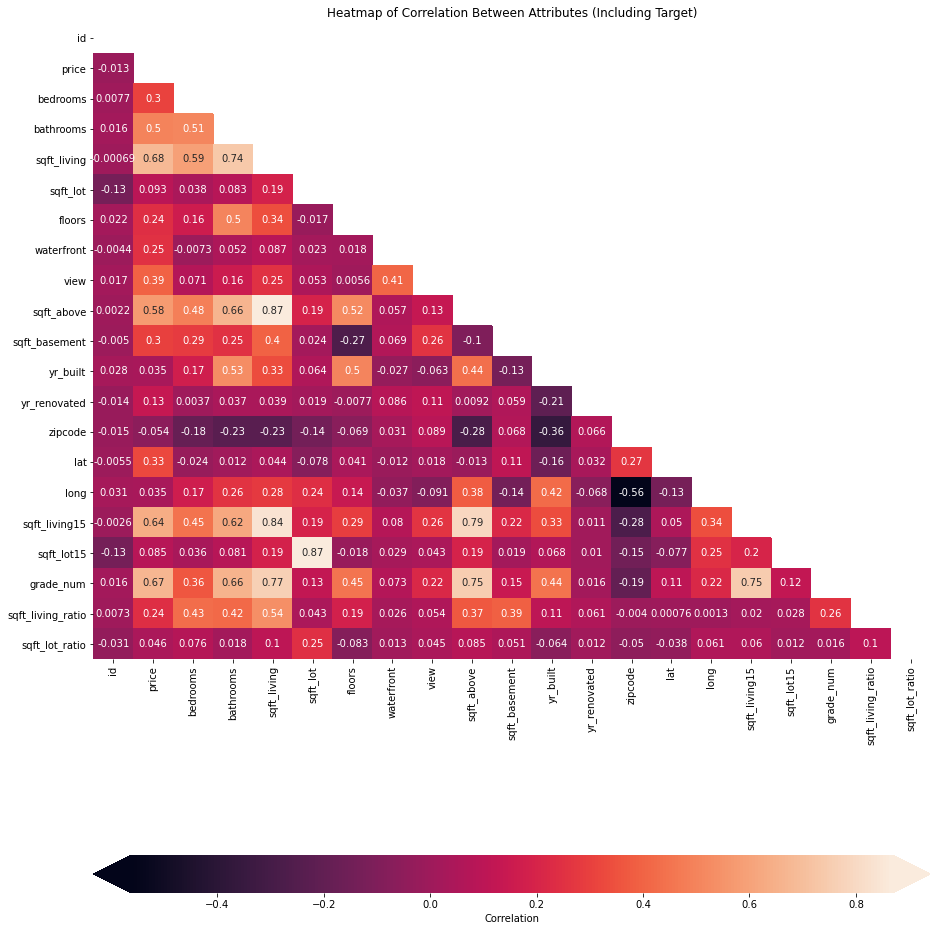

In [13]:
import seaborn as sns
import numpy as np

corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 18))
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [14]:
ohe = OneHotEncoder(sparse = False)
ohe.fit_transform(df[['zipcode']])
zip_encoded = ohe.fit_transform(df[['zipcode']])
zip_enc_df = pd.DataFrame(zip_encoded, columns=ohe.categories_[0], index=df.index)
df_original = pd.concat([df, zip_enc_df], axis=1)
ziplist = ohe.categories_[0].tolist()
zipliststr = []
for i in ziplist: 
    zipliststr.append(str(i))

This cell encodes the zipcode data, and creates a variable of strings to use as column names later. With this, basic preprocessing is done.

### Spliting the data into testing and training sets

In [15]:
X = df_original.drop(columns = ['id','date','lat','long','sqft_living_ratio','sqft_lot_ratio','condition','yr_built','yr_renovated','grade','zipcode'])

### The baseline model

The baseline model we chose to use was a simple model using the information we grabbed from the correlation heatmap, namely that price's highest correlated variable was livable square feet.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='price'),X.price, test_size = .25, random_state = 420)

training_data = pd.concat([X_train,y_train], axis = 1)
testing_data = pd.concat([X_test,y_test], axis = 1)

dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X_train,y_train)
dummy_regr.predict(X_train)
dummy_regr.predict(X_test)
dummy_regr.score(X_train, y_train)
dummy_regr.score(X_test, y_test)
dummy_train_RMSE = MSE(y_train,dummy_regr.predict(X_train),squared = False)
dummy_test_RMSE = MSE(y_test,dummy_regr.predict(X_test), squared = False)

print()
print(f'Baseline Model Train Score: {dummy_regr.score(X_train, y_train)}')
print(f'Baseline Model Train RMSE: {round(dummy_train_RMSE)}')
print()
print(f'Baseline Model Test Score: {dummy_regr.score(X_test, y_test)}')
print(f'Baseline Model Test RMSE: {round(dummy_test_RMSE)}')


Baseline Model Train Score: 0.0
Baseline Model Train RMSE: 332049.0

Baseline Model Test Score: -0.00043488204703723277
Baseline Model Test RMSE: 323803.0


In [ ]:
plt.scatter(baseline_pred_train, baseline_train_residuals)
plt.plot([0, 3000000], [0, 0], color='k', linestyle='-', linewidth=2)
plt.xlabel('label')
### What should I label this?
plt.ylabel('Residual error')
plt.ticklabel_format(style='plain')

In [29]:
X_train_simple_model = X_train[['sqft_living']]
X_test_simple_model = X_test[['sqft_living']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

simple_model = LinearRegression()
simple_model.fit(X_train_simple_model,y_train)

simple_model_scores = cross_validate(
    estimator=simple_model,
    X=df[['sqft_living']],
    y=df.price,
    return_train_score=True,
    cv=splitter
)

simple_predict_train = simple_model.predict(X_train_simple_model)
simple_predict_test = simple_model.predict(X_test_simple_model)

simple_train_RMSE = MSE(y_train,simple_predict_train,squared = False)
simple_test_RMSE = MSE(y_test,simple_predict_test, squared = False)

simple_condition_num = sm.OLS(y_train, sm.add_constant(X_train_simple_model)).fit().condition_number

print(f'Simple Model Train score: {simple_model_scores["train_score"].mean()}')
print(f'Simple Model Train RMSE: {round(simple_train_RMSE)}')
print(f'Simple Model Train Condition Number: {simple_condition_num}')
print()
print("Simple Model Test score: ", simple_model_scores["test_score"].mean())
print(f'Simple Model Test RMSE: {round(simple_test_RMSE)}')

Simple Model Train score: 0.46580936617626406
Simple Model Train RMSE: 243951.0
Simple Model Train Condition Number: 5728.597469721696

Simple Model Test score:  0.4651959378764345
Simple Model Test RMSE: 232732.0


As we can see, the R-squared score isn't great. 

In [33]:
X_train_third_model = X_train[['sqft_living','bedrooms','bathrooms']]
X_test_third_model = X_test[['sqft_living','bedrooms','bathrooms']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

third_model = LinearRegression()
third_model.fit(X_train_third_model,y_train)

third_model_scores = cross_validate(
    estimator=simple_model,
    X=df[['sqft_living','bedrooms','bathrooms']],
    y=df.price,
    return_train_score=True,
    cv=splitter
)

third_predict_train = third_model.predict(X_train_third_model)
third_predict_test = third_model.predict(X_test_third_model)

third_train_RMSE = MSE(y_train,third_predict_train,squared = False)
third_test_RMSE = MSE(y_test,third_predict_test, squared = False)

third_condition_num = sm.OLS(y_train, sm.add_constant(X_train_third_model)).fit().condition_number

print(f'Third Model Train score: {third_model_scores["train_score"].mean()}')
print(f'Third Model Train RMSE: {round(third_train_RMSE)}')
print()
print(f'Third Model Train Condition Number: {third_condition_num}')
print()
print("Third Model Test score: ", third_model_scores["test_score"].mean())
print(f'Third Model Test RMSE: {round(third_test_RMSE)}')

Third Model Train score: 0.48057072089520475
Third Model Train RMSE: 240365.0

Third Model Train Condition Number: 9572.330964466431

Third Model Test score:  0.48001891546634584
Third Model Test RMSE: 230091.0


In [38]:
X_train_fourth_model = X_train
X_test_fourth_model = X_test

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

fourth_model = LinearRegression()
fourth_model.fit(X_train_fourth_model,y_train)

fourth_model_scores = cross_validate(
    estimator=simple_model,
    X=X.drop(columns = 'price'),
    y=X.price,
    return_train_score=True,
    cv=splitter
)

fourth_predict_train = fourth_model.predict(X_train_fourth_model)
fourth_predict_test = fourth_model.predict(X_test_fourth_model)

fourth_train_RMSE = MSE(y_train,fourth_predict_train,squared = False)
fourth_test_RMSE = MSE(y_test,fourth_predict_test, squared = False)

fourth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_fourth_model)).fit().condition_number

print(f'Fourth Model Train score: {fourth_model_scores["train_score"].mean()}')
print(f'Fourth Model Train RMSE: {round(fourth_train_RMSE)}')
print()
print(f'Fourth Model Train Condition Number: {fourth_condition_num}')
print()
print("Fourth Model Test score: ", fourth_model_scores["test_score"].mean())
print(f'fourth Model Test RMSE: {round(fourth_test_RMSE)}')

Fourth Model Train score: 0.8143799561205975
Fourth Model Train RMSE: 143623.0

Fourth Model Train Condition Number: 3.656227830012542e+20

Fourth Model Test score:  0.8102142005063713
fourth Model Test RMSE: 139484.0


In [52]:
X_train_for_RFECV = StandardScaler().fit_transform(X_train)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [55]:
Seattle_zipcodes = [98101, 98102, 98103, 98104, 98105, 
                    98106, 98107, 98108, 98109, 98112, 
                    98115, 98116, 98117, 98118, 98119, 
                    98121, 98122, 98125, 98126, 98133, 
                    98134, 98136, 98144, 98146, 98154, 
                    98164, 98174, 98177, 98178, 98195, 
                    98199 ]

df['in_Seattle'] = np.where(df['zipcode'].isin(Seattle_zipcodes),1,0)


In [58]:
X = df.drop(columns = ['id','date','lat','long','sqft_living_ratio','sqft_lot_ratio', 'sqft_lot15','condition','yr_built','yr_renovated','grade','zipcode'])
X.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,sqft_living15,grade_num,in_Seattle
0,221900.0,3,1.00,1180,5650,1.0,0,0.0,1180,0.0,1340,7,1
1,538000.0,3,2.25,2570,7242,2.0,0,0.0,2170,400.0,1690,7,1
3,604000.0,4,3.00,1960,5000,1.0,0,0.0,1050,910.0,1360,7,1
4,510000.0,3,2.00,1680,8080,1.0,0,0.0,1680,0.0,1800,8,0
5,1230000.0,4,4.50,5420,101930,1.0,0,0.0,3890,1530.0,4760,11,0


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='price'),X.price, test_size = .25, random_state = 420)

training_data = pd.concat([X_train,y_train], axis = 1)
testing_data = pd.concat([X_test,y_test], axis = 1)

As we can see, the R-squared score isn't great. 

In [60]:
X_train_fifth_model = X_train[['sqft_living','bedrooms','bathrooms','in_Seattle']]
X_test_fifth_model = X_test[['sqft_living','bedrooms','bathrooms','in_Seattle']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

fifth_model = LinearRegression()
fifth_model.fit(X_train_fifth_model,y_train)

fifth_model_scores = cross_validate(
    estimator=simple_model,
    X=X[['sqft_living','bedrooms','bathrooms','in_Seattle']],
    y=X.price,
    return_train_score=True,
    cv=splitter
)

fifth_predict_train = fifth_model.predict(X_train_fifth_model)
fifth_predict_test = fifth_model.predict(X_test_fifth_model)

fifth_train_RMSE = MSE(y_train,fifth_predict_train,squared = False)
fifth_test_RMSE = MSE(y_test,fifth_predict_test, squared = False)

fifth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_fifth_model)).fit().condition_number

print(f'Fifth Model Train score: {fifth_model_scores["train_score"].mean()}')
print(f'Fifth Model Train RMSE: {round(fifth_train_RMSE)}')
print()
print(f'Fifth Model Train Condition Number: {fifth_condition_num}')
print()
print("Fifth Model Test score: ", fifth_model_scores["test_score"].mean())
print(f'Fifth Model Test RMSE: {round(fifth_test_RMSE)}')

Fifth Model Train score: 0.5359559808810581
Fifth Model Train RMSE: 227480.0

Fifth Model Train Condition Number: 10408.348434839581

Fifth Model Test score:  0.5404493334175653
Fifth Model Test RMSE: 215395.0


In [87]:
X_train_sixth_model = X_train
X_test_sixth_model = X_test

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

sixth_model = LinearRegression()
sixth_model.fit(X_train_sixth_model,y_train)

sixth_model_scores = cross_validate(
    estimator=simple_model,
    X=X.drop(columns = 'price'),
    y=X.price,
    return_train_score=True,
    cv=splitter
)

sixth_predict_train = sixth_model.predict(X_train_sixth_model)
sixth_predict_test = sixth_model.predict(X_test_sixth_model)

sixth_train_RMSE = MSE(y_train,sixth_predict_train,squared = False)
sixth_test_RMSE = MSE(y_test,sixth_predict_test, squared = False)

sixth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_sixth_model)).fit().condition_number

print(f'Sixth Model Train score: {sixth_model_scores["train_score"].mean()}')
print(f'Sixth Model Train RMSE: {round(sixth_train_RMSE)}')
print()
print(f'Sixth Model Train Condition Number: {sixth_condition_num}')
print()
print("Sixth Model Test score: ", sixth_model_scores["test_score"].mean())
print(f'Sixth Model Test RMSE: {round(sixth_test_RMSE)}')

Sixth Model Train score: 0.6407100283005336
Sixth Model Train RMSE: 200235.0

Sixth Model Train Condition Number: 443881.32470003027

Sixth Model Test score:  0.634617729365014
Sixth Model Test RMSE: 191939.0


In [88]:
X_train_for_RFECV = StandardScaler().fit_transform(X_train)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)
selector.ranking_
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.ranking_[index]}")

bedrooms: 1
bathrooms: 5
sqft_living: 1
sqft_lot: 4
floors: 1
waterfront: 1
view: 1
sqft_above: 2
sqft_basement: 3
sqft_living15: 1
grade_num: 1
in_Seattle: 1


In [89]:
X_train_seventh_model = X_train[['bedrooms','sqft_living','floors','waterfront','view','sqft_living15','grade_num','in_Seattle']]
X_test_seventh_model = X_test[['bedrooms','sqft_living','floors','waterfront','view','sqft_living15','grade_num','in_Seattle']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

seventh_model = LinearRegression()
seventh_model.fit(X_train_seventh_model,y_train)

seventh_model_scores = cross_validate(
    estimator=simple_model,
    X=X.drop(columns = 'price'),
    y=X.price,
    return_train_score=True,
    cv=splitter
)

seventh_predict_train = seventh_model.predict(X_train_seventh_model)
seventh_predict_test = seventh_model.predict(X_test_seventh_model)

seventh_train_RMSE = MSE(y_train,seventh_predict_train,squared = False)
seventh_test_RMSE = MSE(y_test,seventh_predict_test, squared = False)

seventh_condition_num = sm.OLS(y_train, sm.add_constant(X_train_seventh_model)).fit().condition_number

print(f'Seventh Model Train score: {seventh_model_scores["train_score"].mean()}')
print(f'Seventh Model Train RMSE: {round(seventh_train_RMSE)}')
print()
print(f'Seventh Model Train Condition Number: {sixth_condition_num}')
print()
print("Seventh Model Test score: ", sixth_model_scores["test_score"].mean())
print(f'Seventh Model Test RMSE: {round(sixth_test_RMSE)}')

Seventh Model Train score: 0.6407100283005336
Seventh Model Train RMSE: 200297.0

Seventh Model Train Condition Number: 443881.32470003027

Seventh Model Test score:  0.634617729365014
Seventh Model Test RMSE: 191939.0


In [90]:
X_train[['bedrooms','sqft_living','floors','waterfront','view','sqft_living15','grade_num','in_Seattle']].corr()

,bedrooms,sqft_living,floors,waterfront,view,sqft_living15,grade_num,in_Seattle
bedrooms,1.000000,0.589898,0.158781,-0.012094,0.065093,0.446175,0.357486,-0.216498
sqft_living,0.589898,1.000000,0.337649,0.076337,0.253363,0.834496,0.764768,-0.260918
floors,0.158781,0.337649,1.000000,0.020402,0.006105,0.286867,0.451662,0.012305
waterfront,-0.012094,0.076337,0.020402,1.000000,0.413346,0.076624,0.072567,-0.009408
view,0.065093,0.253363,0.006105,0.413346,1.000000,0.265995,0.218110,0.054369
sqft_living15,0.446175,0.834496,0.286867,0.076624,0.265995,1.000000,0.745165,-0.326764
grade_num,0.357486,0.764768,0.451662,0.072567,0.218110,0.745165,1.000000,-0.176670
in_Seattle,-0.216498,-0.260918,0.012305,-0.009408,0.054369,-0.326764,-0.176670,1.000000


In [92]:
X_train_eighth_model = X_train[['bedrooms','floors','waterfront','view','grade_num','in_Seattle']]
X_test_eighth_model = X_test[['bedrooms','floors','waterfront','view','grade_num','in_Seattle']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

eighth_model = LinearRegression()
eighth_model.fit(X_train_eighth_model,y_train)

eighth_model_scores = cross_validate(
    estimator=simple_model,
    X=X.drop(columns = 'price'),
    y=X.price,
    return_train_score=True,
    cv=splitter
)

eighth_predict_train = eighth_model.predict(X_train_eighth_model)
eighth_predict_test = eighth_model.predict(X_test_eighth_model)

eighth_train_RMSE = MSE(y_train,eighth_predict_train,squared = False)
eighth_test_RMSE = MSE(y_test,eighth_predict_test, squared = False)

eighth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_eighth_model)).fit().condition_number

print(f'Eighth Model Train score: {eighth_model_scores["train_score"].mean()}')
print(f'Eighth Model Train RMSE: {round(eighth_train_RMSE)}')
print()
print(f'Eighth Model Train Condition Number: {eighth_condition_num}')
print()
print("Eighth Model Test score: ", eighth_model_scores["test_score"].mean())
print(f'Eighth Model Test RMSE: {round(eighth_test_RMSE)}')

Eighth Model Train score: 0.6407100283005336
Eighth Model Train RMSE: 219659.0

Eighth Model Train Condition Number: 119.2159638322863

Eighth Model Test score:  0.634617729365014
Eighth Model Test RMSE: 214345.0


In [93]:
X_train_for_RFECV = StandardScaler().fit_transform(X_train_eighth_model)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)
selector.ranking_
for index, col in enumerate(X_train_eighth_model.columns):
    print(f"{col}: {selector.ranking_[index]}")

bedrooms: 1
floors: 1
waterfront: 1
view: 1
grade_num: 1
in_Seattle: 1


In [134]:
sm.OLS(y_train, sm.add_constant(X_train_eighth_model)).fit().summary()

final_model = eighth_model.fit(X_train_eighth_model,y_train)
coefficients = pd.DataFrame(final_model.coef_,X_train_eighth_model.columns, columns=['Coefficients'])
print(coefficients)
print(f'Intercept  {round(final_model.intercept_)}')

             Coefficients
bedrooms     42096.067310
floors      -46276.807109
waterfront  517849.827910
view         91203.380011
grade_num   189491.663276
in_Seattle  131393.197867
Intercept  -1058249.0


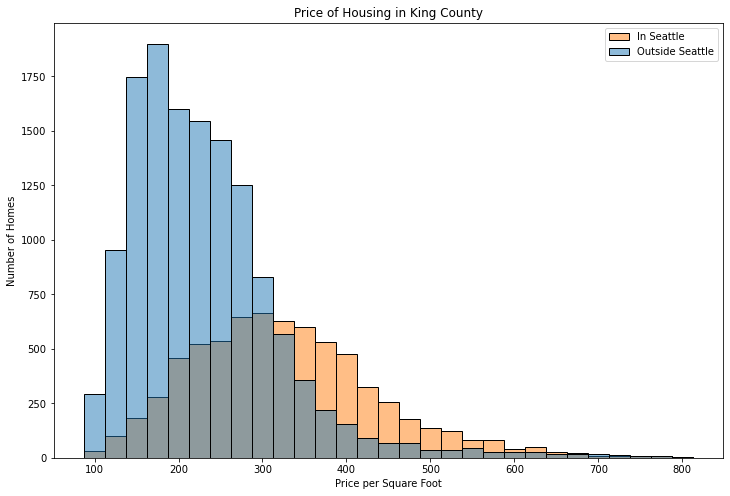

In [119]:
### Look at colinearity btw rooms, sqft_living etc.

df['price_per_sqft'] = df['price'].div(df['sqft_living'])

fig, ax = plt.subplots(figsize = (12,8))
sns.histplot(ax=ax, data = df, x = 'price_per_sqft', hue = 'in_Seattle', binwidth = 25, alpha = .5)
ax.set_xlabel('Price per Square Foot')
ax.set_ylabel('Number of Homes')
ax.set_title('Price of Housing in King County')
ax.legend(['In Seattle','Outside Seattle']);